In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import ellipe
from scipy.special import ellipk

## User input

In [2]:
user = False
raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
units = 'KPC,MSUN/PC**2'
zlaw = 2                            # Case 2: sech-squared density law
mode = zlaw                         # Density distribution mode

# Parameters
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  
CONSTANT = 2.0 * np.pi * G / 3.0
EPS = 1
z0 = 0.93
distance = 16.5                    # Distance in MPC
h = 10.0                           # GUESS: radial scale-length (KPC)
dens0 = 10**2.4                    # GUESS: central surface density (MSUN/KPC^2)

## Case 1: Import density profile

In [3]:
if user == True:
    if units == 'KPC,MSUN/PC**2':
        mudata = np.loadtxt(raddens)
        if np.shape(np.loadtxt(raddens))[1] == 2:     # this just checks if the file has 2 or 4 columns
            xdinp, ydinp = mudata.T
        if np.shape(np.loadtxt(raddens))[1] == 4:
            xdinp, ydinp, xerror, yerror = mudata.T
      
    if units == 'ARCSEC,MAG/ARCSEC**2':
        mudata = np.loadtxt(raddens)
        if np.shape(np.loadtxt(raddens))[1] == 2:
            xdinp, ydinp = mudata.T
        if np.shape(np.loadtxt(raddens))[1] == 4:
            xdinp, ydinp, xerror, yerror = mudata.T
                
        # Conversion
        # ARCSEC to KPC
        xdinp = 4.8481E-3 * distance * xdinp

        # MAG/ARCSEC^2 to MSUN/PC^2
        ydinp = 10**(-0.4 * ydinp)
        ydinp = (4.8481E-3 * distance)**(-2) * ydinp
        
    LEN1 = len(xdinp)                   # GUESS: defined as length of radius array
    LEN2 = len(ydinp)                   # GUESS: defined as lenght of density array
    ndinp = LEN2                        # number of surface densities. GUESS: length of density array again
    rcut = xdinp[ndinp-1]               # takes second to last radius value
    delta = rcut - xdinp[ndinp-2]       # difference between the second to last radius value and the third to last radius value

## Case 2: Calculate density profile 

In [4]:
if user == False:
    
    # User need to provide dens0 (in MSUN/PC^2) and h (in KPC)
    dens0 = dens0           # central density of exponential DISK
    # convert disk central surface brightness from MAG/ARCSEC^2 to MSUN/KPC^2
    #dens0 = 10**(-0.4 * dens0)       
    #dens0 = (4.8481E-3 * distance)**(-2) * dens0
    #dens0 = dens0 * 1.0e6        
    #print("dens0 = {:.4}".format(dens0))

    h = h                   # radial scale length
    z0 = 0.2*h              # scale height of DISK in kpc [0.0]. 
                              # note: The integration in Z is the most time consuming part
                              # of the calculation. For example it takes about 0.2 seconds
                              # to calculate a point on the rotation curve for a disk with zero
                              # thickness, and about 2 seconds for a disk with non-zero thickness.
    rcut = 4*h              # cutoff radius
    delta = 0.2*h           # softening parameter of DISK in kpc [0.0]. It may be wise
                              # to have a non-zero softening in case of a truncated disk, 
                              # because then the sharp features in the calculated rotation 
                              # curve will be smoothed out. A softening parameter of about 
                              # 0.2 scale lengths would be sufficient.

    # Now calculate the surface densities
    LEN1 = 100
    LEN2 = 100
    xdinp = np.zeros(LEN2-1)    # radii surface density
    ydinp = np.zeros(LEN2-1)    # surface densities
    rdinp = rcut + delta      # max radius, where galaxy ends
    ndinp = LEN2 - 1          # number of surface densities
    xstep = rdinp / (ndinp - 1)        # step in radius

    i = 0                              # counter 
    while i < ndinp:
        # Casertano's piecewise function, changed to the partial derivative drho/du
        xdinp[i] = x = xstep * i
        if x >= rcut and delta > 0.0:
            #y = -(1/delta) * dens0 * np.exp(-rcut/h)
            y = dens0 * np.exp(-rcut/h)*(rcut+delta-x)/delta
        elif x >= rdinp:
            y = 0.0                    # end of disk
        else:
            #y = -(1/h) * dens0 * np.exp(-x/h) # exponential disk
            y = dens0 * np.exp(-x/h)
        ydinp[i] = y
        i += 1
print(ydinp)

[251.18864315 240.65083857 230.55511338 220.8829216  211.61649524
 202.73881173 194.23356264 186.08512367 178.27852603 170.79942887
 163.63409296 156.76935547 150.19260577 143.89176227 137.85525022
 132.07198044 126.53132899 121.22311759 116.13759498 111.26541897
 106.5976393  102.12568118  97.84132955  93.736714    89.80429428
  86.03684646  82.4274497   78.96947347  75.65656542  72.48263967
  69.44186568  66.5286575   63.73766351  61.06375662  58.50202483
  56.04776217  53.69646015  51.44379937  49.28564167  47.21802247
  45.23714353  43.33936594  41.52120345  39.77931606  38.11050392
  36.51170137  34.97997139  33.51250018  32.10659196  30.75966406
  29.46924215  28.2329557   27.04853364  25.91380017  24.82667075
  23.78514833  22.7873196   21.83135153  20.91548801  20.03804656
  19.19741533  18.39205005  17.62047126  16.88126156  16.173063
  15.49457461  14.84455     14.22179507  13.62516579  13.05356617
  12.50594615  11.98129975  11.47866319  10.99711312  10.53576492
  10.0937710

## Density distribution

In [5]:
# There are three distribution laws possible; 
# the Van der Kruit and Searle law (SECH-SQUARED): D(Z)=sech(Z/Z0)**2/Z0,
# an exponential density law (EXPONENTIAL): D(Z)=exp(-Z/Z0)/Z0 
# a simple sech law (SIMPLE-SECH): D(Z)=2*sech(Z/Z0)/Z0/PI. 

# case 1 is a flat disk, z0 = 0
#####################################

# Sech-squared law:
def denzed_case2(z,z0): 
    r = np.cosh(z / z0)
    r = r * r * z0
    r = 1.0 / r
    return r

# Exponential:
def denzed_case3(z,z0):
    r = np.exp(-z / z0) /z0
    return r

# Simple-sech
def denzed_case4(z,z0):
    r = 2 / z0 / np.pi / np.cosh(z/z0)
    return r

def denzed(z,z0,mode):
    #mode = input("Which Z density law? 2 or 3 or 4: ")
    #The above results in the user being asked for every point entered; this was likely used as a backend.
    if mode == 2:
        return denzed_case2(z,z0)
    if mode == 3:
        return denzed_case2(z,z0)
    if mode == 4:
        return denzed_case4(z,z0)
    else:
        return np.nan
        print("Error occured in denzed; no mode selected. Returned nan.")

In [6]:
# Casertano Eq 2
def drho_rz(ydinp,z,z0,mode):
    return ydinp * denzed(z,z0,mode) #r should be the density instead

## Lagrange interpolation

In [7]:
# interp does a Lagrange interpolation (second order)
def interpd(x1,y1,n1,x2,y2,n2):  
    i = 0

    while i < n2:
        x = x2[i]
        y = 0.0
        j = 1
        done = 0
        while (done != 1) and (j < (n1 - 3)):
            if ((x1[j-1] <= x ) and (x1[j+1] >= x)):
                k = j - 1
                while (k <= j + 1):
                    f = 1.0
                    l = j - 1
                    while l <= j + 1:
                        if (l != k):
                            f *= (x - x1[l]) / (x1[k] - x1[l])
                        l += 1        
                    y += f * y1[k]
                    k += 1 
                done = 1
            j += 1
        if (y > 0.0):
            y2[i] = y
        else: 
            y2[i] = 0.0
        i += 1
    return x2,y2

## Functions

In [8]:
# Casertano Eq 5
def px(r,u,z):
    x = (r**2 + u**2 + z**2)/(2*r*u)
    return x - (np.sqrt((x**2)-1))

In [9]:
# Complete elliptic integral
def K(r,u,z):
    return ellipk(px(r,u,z)) - ellipe(px(r,u,z))

In [10]:
# Inner function
def innerfunc(r,u,z,z0,mode):
    return (4 * np.pi * G) * (drho_rz(r,z,z0,mode) * K(r,u,z) * 2 * np.sqrt(u)) / (np.pi * np.sqrt(r * px(r,u,z)))

In [11]:
# Define arrays
nradii = len(xdinp)
radius = xdinp
radius[0] = 0.000000000001             # prevent division by zero error
densit = np.zeros(LEN1+LEN2+1)

radius = interpd(xdinp, ydinp, ndinp, radius, densit, nradii)[0]
densit = interpd(xdinp, ydinp, ndinp, radius, densit, nradii)[1]

r = radius
u = np.arange(0,np.max(xdinp),0.2*h)
z = np.array([0.02, 0.50, 1.00, 3.00, 10.00])

In [12]:
print(densit)
print(ydinp)

[251.18864315 240.65083857 230.55511338 220.8829216  211.61649524
 202.73881173 194.23356264 186.08512367 178.27852603 170.79942887
 163.63409296 156.76935547 150.19260577 143.89176227 137.85525022
 132.07198044 126.53132899 121.22311759 116.13759498 111.26541897
 106.5976393  102.12568118  97.84132955  93.736714    89.80429428
  86.03684646  82.4274497   78.96947347  75.65656542  72.48263967
  69.44186568  66.5286575   63.73766351  61.06375662  58.50202483
  56.04776217  53.69646015  51.44379937  49.28564167  47.21802247
  45.23714353  43.33936594  41.52120345  39.77931606  38.11050392
  36.51170137  34.97997139  33.51250018  32.10659196  30.75966406
  29.46924215  28.2329557   27.04853364  25.91380017  24.82667075
  23.78514833  22.7873196   21.83135153  20.91548801  20.03804656
  19.19741533  18.39205005  17.62047126  16.88126156  16.173063
  15.49457461  14.84455     14.22179507  13.62516579  13.05356617
  12.50594615  11.98129975  11.47866319  10.99711312  10.53576492
  10.0937710

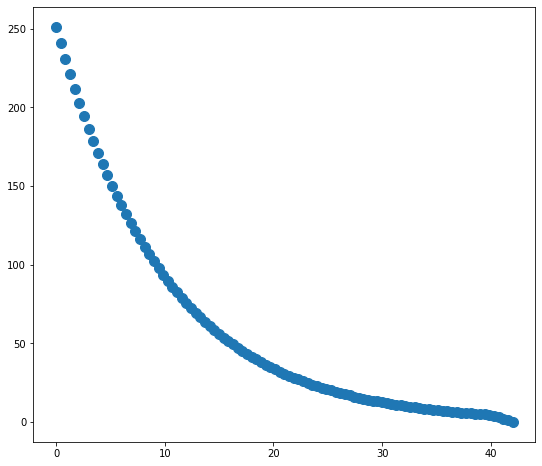

In [13]:
# Plot 
plt.figure(figsize=(9,8))
plt.scatter(xdinp,ydinp, s=100)
#plt.scatter(radius,densit)
plt.show()

## Integration

In [14]:
# Integrate inner function
innerfunc2 = lambda z,r,u,z0,mode: innerfunc(r,u,z,z0,mode)
innerintegr1 = lambda r,u,z0,mode: quad(innerfunc2, 0, np.inf, args=(r,u,z0,mode,))[0]

In [15]:
# Integrate outer function
innerintegr2 = lambda u,r,z0,mode: innerintegr1(r,u,z0,mode)
radialforce = lambda r,z0,mode: quad(innerintegr2, 0.1, 125, args=(r,z0,mode,))[0]

## Velocity

In [16]:
radialforce = np.vectorize(radialforce)
velocs = np.sqrt(densit*radialforce(densit,z0,mode))

/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/home/gerudo7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in cosh
  # This is added back by InteractiveShellApp.init_path()


ZeroDivisionError: float division by zero

## Plot

In [ ]:
plt.figure(figsize=(9.0,8.0))             
plt.scatter(radius, velocs, linestyle='solid', label='Gas Velocity')
plt.axis('tight');
plt.title('NGC 5533')
plt.xlabel('Radius (KPC)', fontsize=14)
plt.ylabel('Velocity (KM/S)', fontsize=14)
plt.legend(fontsize=16)
plt.show()

In [ ]:
print(radius)
print(velocs)